In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

%cd "/content/drive/My Drive/CitNet"
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/CitNet
 confusion_matrix.ipynb   data_summary.ipynb   output/
 data/                   'Deep GCN.ipynb'      PCA.ipynb
'Data Summary.gdoc'       method/              train_test_split.ipynb


In [0]:
! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
import time

import numpy as np
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F


DATA_TYPE = "small"
DATA_TYPE = "raw"

EVAL_INTERVAL = 2

if DATA_TYPE == "small":
    FEATURE_PATH = "data/small/feature.csv"
    LABEL_PATH = "data/small/target_with_mask_80.csv"
    OUTPUT_PATH = "output/small/NN.csv"
    NODE_NUM = 2708

    FEATURE_NUM = 1432
    HIDDEN_NUM = 100
    CLASS_NUM = 7

    # PCA_COMPONENTS = 1200

    BATCH_SIZE = 256
    EPOCHS = 60
    LR = 0.1

else:
    FEATURE_PATH = "data/raw/feature.csv"
    LABEL_PATH = "data/raw/target_with_mask_20.csv"
    OUTPUT_PATH = "output/raw/NN.csv"
    NODE_NUM = 11881

    FEATURE_NUM = 9568
    HIDDEN_NUM = 100
    CLASS_NUM = 10

    # PCA_COMPONENTS = 6000

    BATCH_SIZE = 256
    EPOCHS = 80
    LR = 0.1


In [0]:
def read_features():    
    features = np.zeros((NODE_NUM, FEATURE_NUM), dtype=np.float32)
    with open(FEATURE_PATH, "r") as f:
        next(f)
        for line in f:
            node_id, feature_id, feature_val = line.strip().split(",")
            node_id = int(node_id)
            feature_id = int(feature_id)
            feature_val = float(feature_val)

            features[node_id, feature_id] = feature_val    
    return features
    
def read_labels():
    labels = np.zeros((NODE_NUM, 2), dtype=np.int64)
    # labels = np.zeros((NODE_NUM, ), dtype=np.int64)
    with open(LABEL_PATH, "r") as f:
        next(f)
        for line in f:
            node_id, class_id, is_train = line.strip().split(",")
            node_id = int(node_id)
            
            if DATA_TYPE == "small":
                class_id = int(class_id)
            else:
                class_id = int(class_id.split("\t")[0])  # May need random here

            # labels[node_id] = class_id
            labels[node_id, 0] = class_id
            labels[node_id, 1] = is_train
    return labels

def split_dataset():
    features = read_features()
    labels = read_labels()
    
    training_idx = np.where(labels[:, 1] == 1)
    testing_idx = np.where(labels[:, 1] == 0)
    

    # indices = np.random.RandomState(seed=42).permutation(NODE_NUM)
    # training_idx, testing_idx = indices[:int(NODE_NUM * SPLIT_RATIO)], indices[int(NODE_NUM * SPLIT_RATIO):]
    
    # training = (features[training_idx], labels[training_idx])
    # testing = (features[testing_idx], labels[testing_idx])
    training = (features[training_idx], np.squeeze(labels[training_idx, 0]))
    testing = (features[testing_idx], np.squeeze(labels[testing_idx, 0]))


    print(training[0].shape, training[1].shape)
    return training, testing

In [0]:
class NodeDataset(Dataset):
    def __init__(self, data):
        self.features = data[0]
        self.labels = data[1]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

In [0]:
class SMALL_NET(nn.Module):
    def __init__(self):
        super().__init__()
        # self.fc = nn.Linear(FEATURE_NUM, CLASS_NUM)
        self.fc1 = nn.Linear(FEATURE_NUM, HIDDEN_NUM)
        self.fc2 = nn.Linear(HIDDEN_NUM, CLASS_NUM)
        # self.LReLU = nn.LeakyReLU(negative_slope=0.05)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        # x = self.fc(x)

        x = self.fc1(x)
        x = F.relu(x)
        # x = self.LReLU(x)
        x = self.drop(x)
        x = self.fc2(x)

        return x
        
class RAW_NET(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(FEATURE_NUM, CLASS_NUM)

        self.fc1 = nn.Linear(FEATURE_NUM, HIDDEN_NUM)
        self.fc2 = nn.Linear(HIDDEN_NUM, CLASS_NUM)
        # self.LReLU = nn.LeakyReLU(negative_slope=0.05)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        # x = self.fc(x)

        x = self.fc1(x)
        x = F.relu(x)
        # x = self.LReLU(x)
        x = self.drop(x)
        x = self.fc2(x)

        return x

In [0]:
def train(net, data_loader, optimizer, criterion, epoch):
    total_loss = 0

    pbar = tqdm(data_loader, position=0, leave=True)
    for step, data in enumerate(pbar):
        # try:
        #     data = next(data_iter) 
        # except StopIteration:
        #     data_iter = iter(data_loader)
        #     data = next(data_iter) 
        
        features, labels = data
        features, labels = features.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(features)
        # print(features.size(), labels.size())
        # print(outputs.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_description("[EPOCH: {}] loss = {:.04f}".format(epoch, total_loss / (step+1)))
    
    ave_loss = total_loss / len(data_loader)
    return ave_loss
        
def test(net, data_loader, tag):
    correct = total = 0

    pbar = tqdm(data_loader, position=0, leave=True)
    with torch.no_grad():
        for data in pbar:
            features, labels = data
            features, labels = features.cuda(), labels.cuda()

            outputs = net(features)
            _, preds = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()           

            pbar.set_description("{} Acc: {:.2f}".format(tag, correct / total * 100))

    ave_acc = correct / total
    return ave_acc

def inference(net, data_loader):
    res = []
    with torch.no_grad():
        for data in data_loader:
            features, labels = data
            features, labels = features.cuda(), labels.cuda()

            outputs = net(features)
            _, preds = torch.max(outputs.data, 1)

            preds, labels = preds.cpu(), labels.cpu()
            for pred, label in zip(preds, labels):
                res.append([label.item(), pred.item()])

    res = np.array(res)
    return res

def plot(train_loss, train_acc, test_acc, interval):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
    axes[0].plot(train_loss)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    
    axes[1].plot(range(1, len(train_acc) * interval + 1, interval), train_acc)
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    
    axes[2].plot(range(1, len(test_acc) * interval + 1, interval), test_acc)
    axes[2].set_title('Testing Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')

In [58]:

if DATA_TYPE == "small":
    net = SMALL_NET()
else:
    net = RAW_NET()

net = net.cuda()

optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
# optimizer = optim.Adagrad(net.parameters(), lr=LR)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()


train_dataset, test_dataset = split_dataset()
train_dataset = NodeDataset(train_dataset)
test_dataset = NodeDataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                shuffle=True, num_workers=4, drop_last=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, num_workers=4, drop_last=False)


train_losses, train_accs, test_accs = [], [], []
for epoch in range(EPOCHS):
    train_loss = train(net, train_loader, optimizer, criterion, epoch + 1)

    train_losses.append(train_loss)

    if (epoch + 1) % EVAL_INTERVAL == 0:
        train_acc = test(net, train_loader, "Train")
        test_acc = test(net, test_loader, "Test ")

        train_accs.append(train_acc)
        test_accs.append(test_acc)


  0%|          | 0/10 [00:00<?, ?it/s]

(2376, 9568) (2376,)


Test  Acc: 57.85: 100%|██████████| 38/38 [00:00<00:00, 57.58it/s]


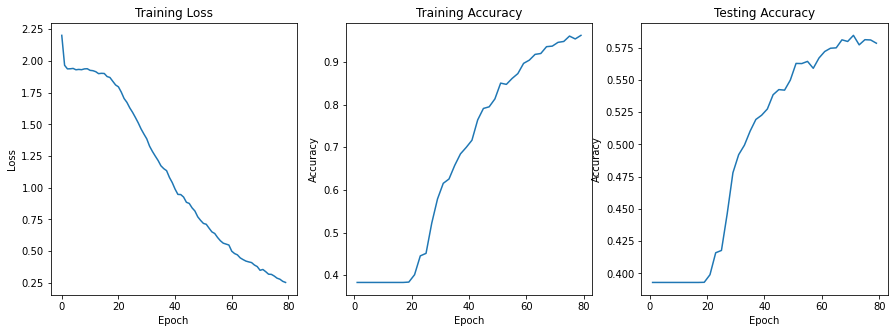

In [59]:
plot(train_losses, train_accs, test_accs, EVAL_INTERVAL)

In [0]:
# res = inference(net, test_loader)

# df = pd.DataFrame(res)
# df.to_csv(OUTPUT_PATH, header=["gt", "pred"], index=False)